#7.1 RNN 개요

- 일반적인 신경망이나 CNN은 시간의 개념이 없음..
- 컴퓨터가 글을 쓰고 이해하려면 **순서**가 중요하다.

**RNN의 작동 방식**

- RNN은 시계열 데이터의 정보를 하나씩 입력받을 때마다 여태껏 입력받은 벡터를 종학하여 **은닉 벡터**를 만들어낸다.
- 결국, **마지막 은닉 벡터**는 배열 속 모든 벡터의 내용을 압축한 벡터가 된다..
- ex) LSTM, GRU.. -> 언어 모델링, 텍스트 감정 분석, 기계 번역..

#7.2 영화 리뷰 감정 분석

- 영화 리뷰를 RNN을 이용해서 내용 압축
- 압축된 리뷰에 대한 긍정/부정을 판단하는 분류 모델 생성
    - **워드 임베딩** : 언어의 최소단위인 토큰을 벡터 형태로 변환하는 작업

##7.2.1 자연어 전처리

In [1]:
#토치텍스트 사용..

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets

In [2]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


###IMDB 데이터 로딩

In [3]:
# 데이터 로딩하기
print("데이터 로딩중...")

#sequential : 순차적인지..
#batch_first : 입력 텐서의 첫번째 차원값을 batch_size로 지정..
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

데이터 로딩중...


In [4]:
#테스트 세트 지정..
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 39.6MB/s]


단어사전 만들기
- 최소 5회 이상 나온 단어들만..
- 이하는 unk으로 대체..

In [5]:
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

검증세트는 따로 만들어야함

In [6]:
# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)

# 배치크기만큼 배치 생성하는 반복자 생성..
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

In [7]:
vocab_size = len(TEXT.vocab)        #단어사전 크기
n_classes = 2                       #레이블 수

데이터셋 분리 결과 확인..

In [8]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


##7.2.2 RNN 모델 구현

In [9]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers        #층수
        #단어 임베딩..(단어사전크기, 임베딩 후 차원)
        self.embed = nn.Embedding(n_vocab, embed_dim)
        #은닉차원
        self.hidden_dim = hidden_dim
        #드롭아웃 비율..
        self.dropout = nn.Dropout(dropout_p)

        #일반적인 RNN은 그레이디언트 폭주/소실 문제로 인해 사용 안함.
        #이를 보완한 GRU 사용
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        
        #마지막 신경망 통과..
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)   #단어 임베딩된 x
        h_0 = self._init_state(batch_size=x.size(0))        #첫번째 가중치 텐서..

        #x에 모든 은닉벡터를 모아놓았다..
        x, _ = self.gru(x, h_0)  # [i, b, h]

        #마지막 은닉벡터만 가져온다..
        #모든 벡터에 대한 정보가 담김..
        h_t = x[:,-1,:]

        #드롭아웃..
        self.dropout(h_t)
        #신경망을 통과시켜 결과 확인..
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data       #첫번째 가중치 텐서를 추출..
        #첫 가중치 텐서 크기만큼의 0 텐서를 반환.
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

훈련함수 구현

In [10]:
def train(model, optimizer, train_iter):
    model.train()   #훈련모드
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)    #모델 예측..
        loss = F.cross_entropy(logit, y)        #손실..
        loss.backward()     #역전파..
        optimizer.step()    #다음스텝...

평가함수 구현

In [11]:
def evaluate(model, val_iter):
    model.eval()    #평가모드
    corrects, total_loss = 0, 0

    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환

        logit = model(x)        #예측..

        #손실 구하기,,
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()   #손실 총 합 계산

        #예측의 값이 제일 큰 놈의 인덱스가 레이블과 같으면 corrects를 1 증가
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)

    avg_loss = total_loss / size                #평균손실..
    avg_accuracy = 100.0 * corrects / size      #정답률..
    return avg_loss, avg_accuracy

모델 및 최적화함수 객체 생성
- Adam 최적화함수 사용 (국룰)

In [12]:
#은닉벡터 256차원.. 임베딩된 토큰 128차원..
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


###학습하기

In [13]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.69 | 검증 정확도:49.52
[이폭: 2] 검증 오차: 0.70 | 검증 정확도:49.36
[이폭: 3] 검증 오차: 0.69 | 검증 정확도:54.56
[이폭: 4] 검증 오차: 0.63 | 검증 정확도:62.88
[이폭: 5] 검증 오차: 0.36 | 검증 정확도:84.60
[이폭: 6] 검증 오차: 0.33 | 검증 정확도:85.46
[이폭: 7] 검증 오차: 0.41 | 검증 정확도:84.88
[이폭: 8] 검증 오차: 0.42 | 검증 정확도:86.08
[이폭: 9] 검증 오차: 0.41 | 검증 정확도:85.18
[이폭: 10] 검증 오차: 0.45 | 검증 정확도:86.06


###평가하기

In [14]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.34 | 테스트 정확도: 85.48


#7.3 Seq2Seq 기계 번역

- 문장을 다른 문장으로 번역해주는 모델
- 여기서는 "hello"를 "hola"로 번역하는 미니 Seq2Seq 모델을 만들자..

##7.3.1 Seq2Seq 개요

- 각 자 다른 역할을 하는 두 개의 RNN을 이어붙힌 모델
- 인코더 & 디코더

##7.3.2 인코더


- 원문의 내용을 학습하는 RNN
- 압축된 텐서(마지막 토큰의 은닉벡터)는 원문의 뜻과 내용을 압축하고 있다고 해서 **문맥 벡터**라고 한다.

##7.3.3 디코더

- 인코더에서 원문 문맥 벡터를 이어받아 번역문 속의 토큰을 차례대로 예상
- 디코더는 번역문의 토큰을 출력할 때 **인코더로부터 정보를 전달 받아야함**

##7.3.4 Seq2Seq 모델 구현하기

- 인코더가 문맥벡터 생성
- 디코더가 그걸 받아서 번역문 예측
- 실제 번역문 사이의 오차를 줄여나가는 방식으로 작동..

여기서는 미니 Seq2Seq이니까 단어임베딩이 아닌 **캐릭터임베딩**실시

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

아스키코드로 임베딩..

In [16]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [17]:
#텐서로 변환..
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

###모델 생성

- 티쳐포싱 사용
    - 원래 디코더가 예측한 토큰을 다음 반복에서 입력될 토큰으로 갱신해야함
    - BUT, 학습되지 않은 상태의 모델은 잘못된 예측토큰을 입력할 가능성이 높다..
    - 이를 방지하기위해 **티쳐포싱**을 사용한다

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size      #은닉차원..
        #임베딩층..
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)     #인코더..
        self.decoder = nn.GRU(hidden_size, hidden_size)     #디코더..
        self.project = nn.Linear(hidden_size, vocab_size)   #일반신경망..

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        #캐릭터 임베딩..
        embedding = self.embedding(inputs).unsqueeze(1)
        
        # 인코더 (Encoder)
        #encoder_state : 문맥 벡터..
        encoder_output, encoder_state = self.encoder(embedding, initial_state)

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        #디코더에 문장시작을 알리기 위해 0으로 설정..
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            #결괏값을 다시 디코더에 넣음..
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            #신경망으로 예측..
            projection = self.project(decoder_output)
            #예측값 append
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            #직접적으로 디코더를 위한 입력토큰 갱신
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    #초기 가중치 크기 지정 함수..
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

모델 객체 생성

In [19]:
seq2seq = Seq2Seq(vocab_size, 16)

필요한 객체 생성..

In [20]:
criterion = nn.CrossEntropyLoss()       #크로스 엔트로피 오차 구하는 객체
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)     #최적화 알고리즘 객체

###모델 학습

In [21]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)          #예측..
    loss = criterion(prediction, y)     #손실 계산..
    optimizer.zero_grad()               #기울기 계산 시작한다..
    loss.backward()     #역전파..
    optimizer.step()    #다음 스텝..

    #손실값을 저장..
    loss_val = loss.data        
    log.append(loss_val)

    #백번째 에포크 마다 실행..
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        #예측값을 가지고 확인해보자..
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.411283016204834
['K', 'V', 'f', 'a']

 반복:100 오차: 2.004889488220215
['h', 'o', 'a', 'a']

 반복:200 오차: 0.5124512314796448
['h', 'o', 'l', 'a']

 반복:300 오차: 0.26142051815986633
['h', 'o', 'l', 'a']

 반복:400 오차: 0.16455115377902985
['h', 'o', 'l', 'a']

 반복:500 오차: 0.11463146656751633
['h', 'o', 'l', 'a']

 반복:600 오차: 0.08581574261188507
['h', 'o', 'l', 'a']

 반복:700 오차: 0.06734844297170639
['h', 'o', 'l', 'a']

 반복:800 오차: 0.05459779500961304
['h', 'o', 'l', 'a']

 반복:900 오차: 0.045322805643081665
['h', 'o', 'l', 'a']


오차 확인..

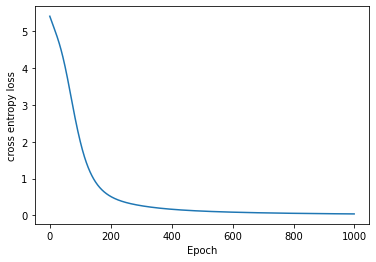

In [23]:
plt.plot(log)
plt.xlabel('Epoch')
plt.ylabel('cross entropy loss')
plt.show()